In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [43]:
df = pd.read_csv('bnk.csv',sep=';')

In [44]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [45]:
def check_missing_values(data):
    missing_values = data.isnull().sum()
    percent_missing = (missing_values / data.shape[0]) * 100
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'missing_values': missing_values,
                                     'percent_missing': percent_missing})
    return missing_value_df[missing_value_df['missing_values'] > 0]


In [46]:
check_missing_values (df)

,column_name,missing_values,percent_missing


In [47]:
def check_unknown_values(data):
    unknown_values = {}
    for column in data.select_dtypes(include=['object']).columns:
        count = (data[column] == 'unknown').sum()
        if count > 0:
            unknown_values[column] = [count, (count / data.shape[0]) * 100]
    return pd.DataFrame(unknown_values, index=['unknown_values', 'percent_unknown']).transpose()

In [48]:
check_unknown_values (df)

,unknown_values,percent_unknown
job,330.0,0.801204
marital,80.0,0.194231
education,1731.0,4.202680
default,8597.0,20.872584
housing,990.0,2.403613
loan,990.0,2.403613


In [49]:
def handle_unknown_values(data, strategy='drop', columns=None):
    data_modified = data.copy()
    if not columns:
        columns = data_modified.select_dtypes(include=['object']).columns
    for column in columns:
        if strategy == 'drop':
            data_modified = data_modified[data_modified[column] != 'unknown']
        elif strategy == 'impute':
            mode_value = data_modified[column].mode()[0]
            data_modified.loc[data_modified[column] == 'unknown', column] = mode_value
    return data_modified

In [50]:
df = handle_unknown_values (df)

In [51]:
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [52]:
def handle_outliers(data, columns=None, method='iqr', action='cap'):
    data_modified = data.copy()
    if not columns:
        columns = data_modified.select_dtypes(include=['number']).columns
    for column in columns:
        if method == 'iqr':
            Q1 = data_modified[column].quantile(0.25)
            Q3 = data_modified[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if action == 'remove':
                data_modified = data_modified[(data_modified[column] >= lower_bound) & (data_modified[column] <= upper_bound)]
            elif action == 'cap':
                data_modified[column] = data_modified[column].clip(lower_bound, upper_bound)
    return data_modified

In [53]:
handle_outliers(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,66,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [54]:
# df = convert_data_types(df)
def statistical_summary(data):
    return data.describe()


In [81]:
statistical_summary(df)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000
mean,39.029694,259.513124,2.521721,956.318295,0.194337,-0.071425,93.523376,-40.602579,3.459976,5160.813967
std,10.332746,261.746393,2.720495,201.404843,0.522862,1.610306,0.585366,4.788790,1.777215,75.158267
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [56]:
def plot_feature_distribution(data, columns=None, bins=30):
    if not columns:
        columns = data.select_dtypes(include=['number']).columns
    for column in columns:
        plt.figure(figsize=(10, 4))
        sns.histplot(data[column], bins=bins, kde=True)
        plt.title(f'Distribution of {column}')
        plt.ylabel('Frequency')
        plt.xlabel(column)
        plt.show()

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


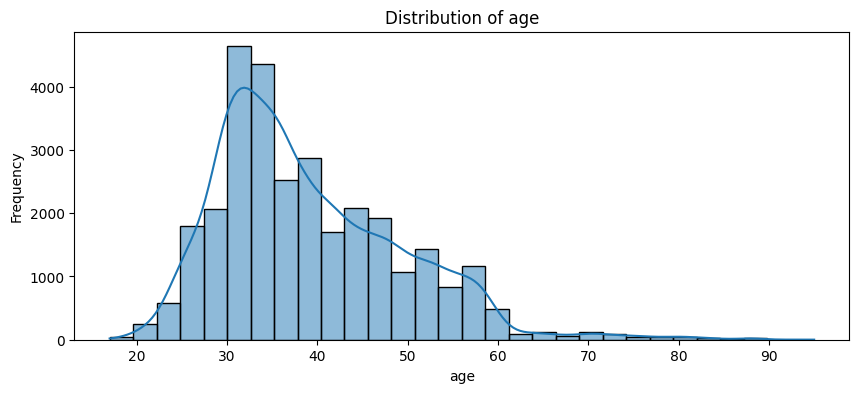

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


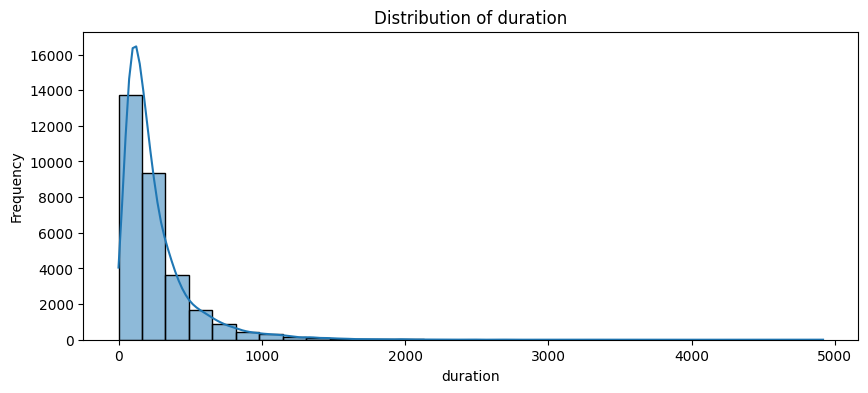

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


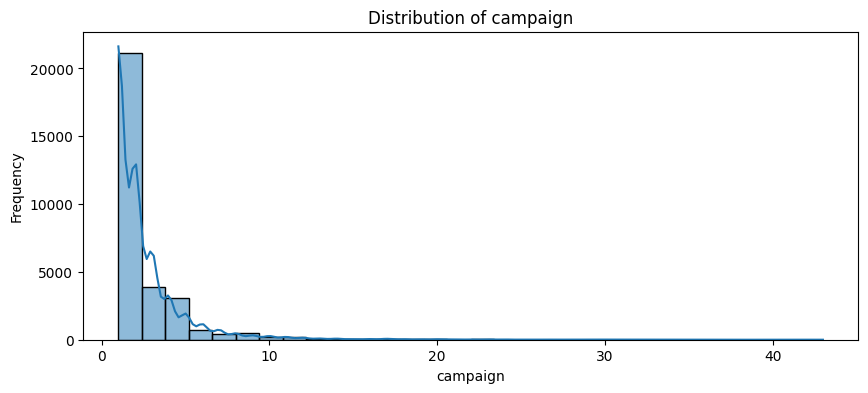

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


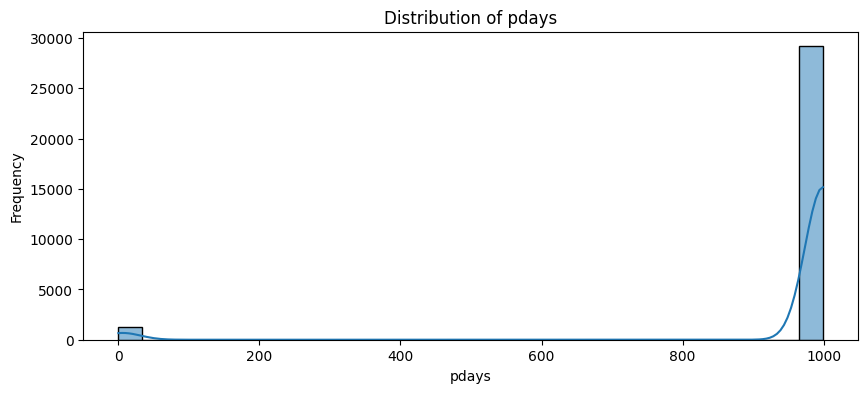

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


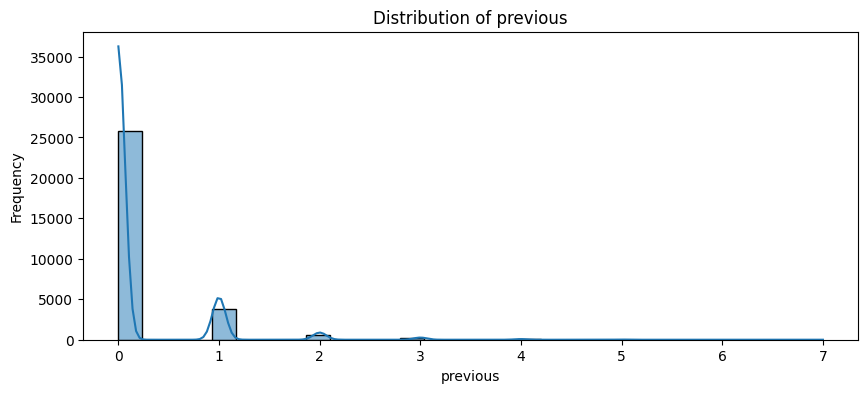

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


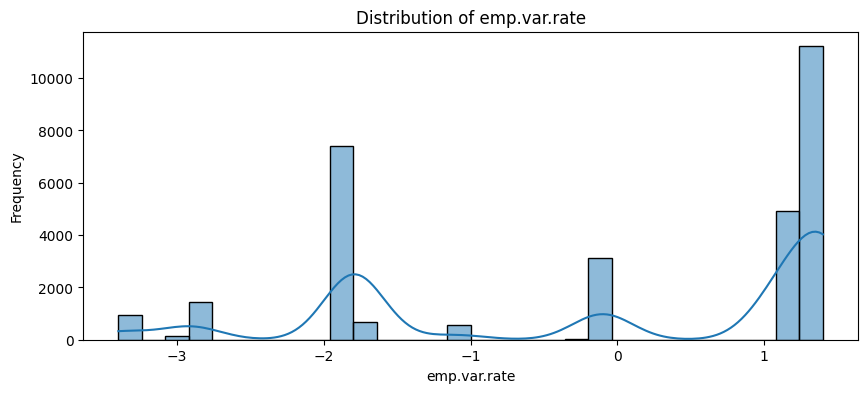

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


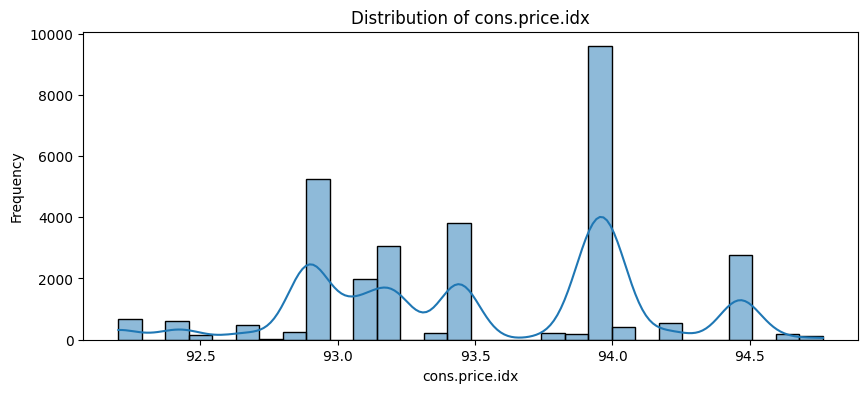

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


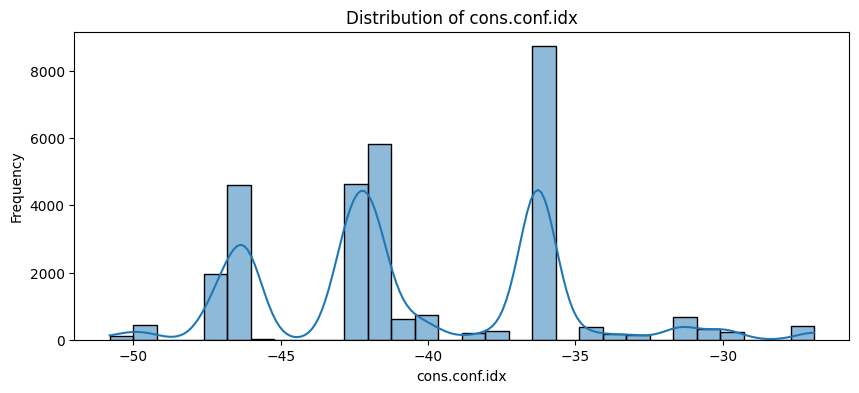

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


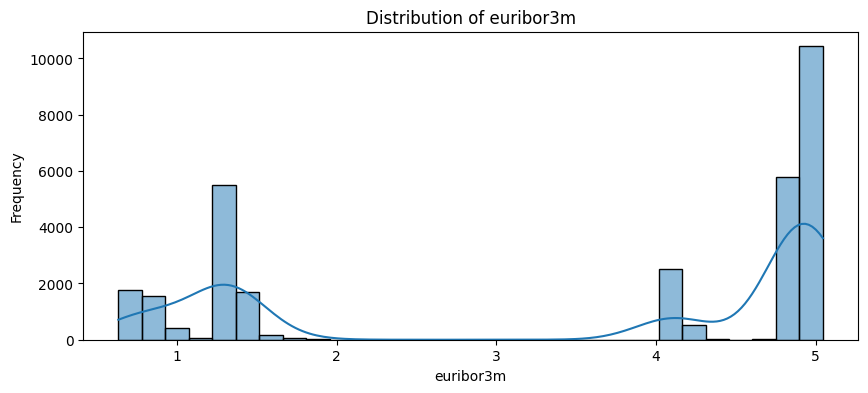

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


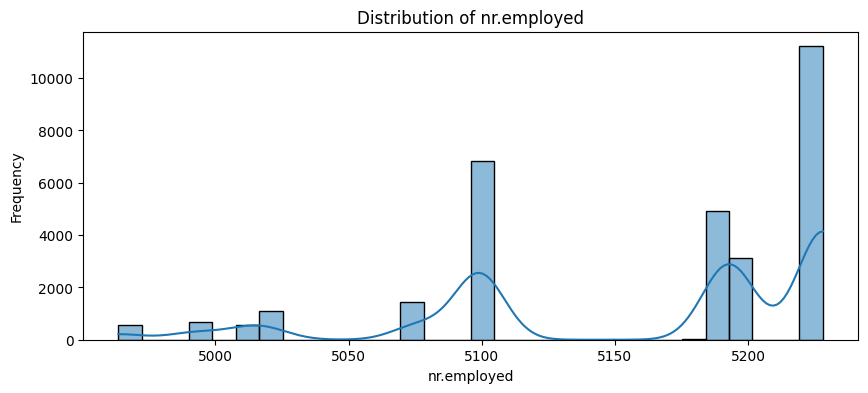

In [57]:
plot_feature_distribution(df)


In [58]:
df_encoded = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])

In [59]:
df_encoded

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,False,True,False
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,False,True,False
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,False,True,False
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,False,True,False
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,False,False,False,True,False
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,False,False,False,True,False
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,False,False,False,True,False
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,False,False,True,False,False,False,False,False,True,False


In [78]:
X = df_encoded.drop('y',axis=1)
y = df_encoded['y']
y = (y == 'yes').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
def train_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train,y_train,batch_size=50,epochs=30,validation_split=0.2,validation_data=(X_test,y_test),callbacks=[early_stopping])
    print(f'-------------------------- Model Evaluation -------------------')
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_acc}')
    return model


In [79]:
model = train_model()

Epoch 1/30


/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7471 - loss: 0.5639 - val_accuracy: 0.8766 - val_loss: 0.2288
Epoch 2/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8817 - loss: 0.2570 - val_accuracy: 0.8830 - val_loss: 0.2211
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8872 - loss: 0.2333 - val_accuracy: 0.8882 - val_loss: 0.2185
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8840 - loss: 0.2338 - val_accuracy: 0.8782 - val_loss: 0.2229
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8858 - loss: 0.2284 - val_accuracy: 0.8910 - val_loss: 0.2192
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8961 - loss: 0.2137 - val_accuracy: 0.8874 - val_loss: 0.2202
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8937 - loss: 0.2059 - val_accuracy: 0.8911 - val_loss: 0.2170
Epoch 8/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8936 - loss: 0.2123 - val_accuracy: 0.8890 - val_

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


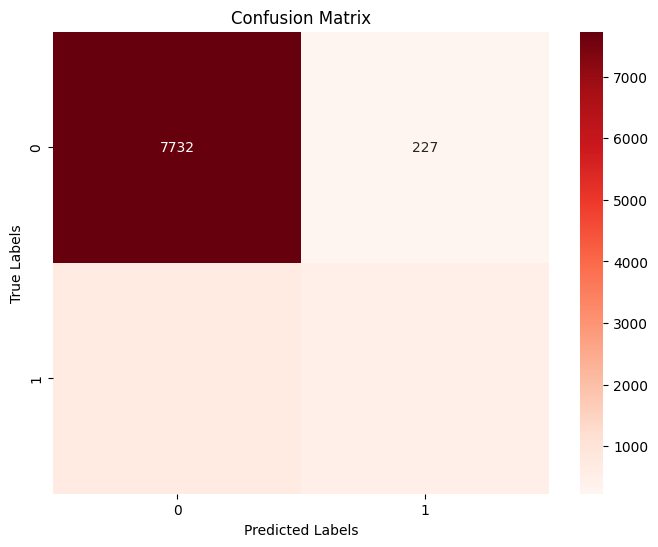

In [80]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()